# Project 2: Ames Housing Data and Kaggle Challenge

## Part II - Modeling

Author: Charles Ramey

Date: 03/19/2023

---

#### Links

For the first and second iterations, see the following notebooks:
- [`Part-2.1_model-iteration-1.ipynb`](../code/Part-2.1_model-iteration-1.ipynb)
- [`Part-2.2_model-iteration-2.ipynb`](../code/Part-2.2_model-iteration-2.ipynb)

To see the conclusions and recommendations of this project, see the following notebook:
- [`Part-3_conclusion-and-recommendations.ipynb`](../code/Part-3_conclusion-and-recommendations.ipynb)

### Contents

- [Preprocessing](#Preprocessing)
- [Linear Model](#Linear-Model)
- [Ridge Model](#Ridge-Model)
- [Lasso Model](#Lasso-Model)
- [ElasticNet Model](#ElasticNet-Model)
- [Predictions](#Predictions)

## Model Iteration 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn import set_config

import warnings

In [2]:
set_config(transform_output='pandas')

In [3]:
df_train = pd.read_csv('../datasets/train_cleaned.csv')
df_test = pd.read_csv('../datasets/test_cleaned.csv')
df_train

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,...,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,13517,Pave,IR1,Lvl,AllPub,CulDSac,...,44,0,0,0,0,0,3,2010,WD,130500
1,544,531379050,60,RL,11492,Pave,IR1,Lvl,AllPub,CulDSac,...,74,0,0,0,0,0,4,2009,WD,220000
2,153,535304180,20,RL,7922,Pave,Reg,Lvl,AllPub,Inside,...,52,0,0,0,0,0,1,2010,WD,109000
3,318,916386060,60,RL,9802,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,4,2010,WD,174000
4,255,906425045,50,RL,14235,Pave,IR1,Lvl,AllPub,Inside,...,59,0,0,0,0,0,3,2010,WD,138500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,921126030,20,RL,11449,Pave,IR1,HLS,AllPub,Inside,...,276,0,0,0,0,0,1,2008,WD,298751
2047,785,905377130,30,RL,12342,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,0,3,2009,WD,82500
2048,916,909253010,50,RL,7558,Pave,Reg,Bnk,AllPub,Inside,...,0,0,0,0,0,0,3,2009,WD,177000
2049,639,535179160,20,RL,10400,Pave,Reg,Lvl,AllPub,Corner,...,189,140,0,0,0,0,11,2009,WD,144000


### Preprocessing & Feature Engineering

This iteration seeks to find a balance between the simplicity of the first iteration, and the high-variance second iteration. To do so, we will attempt to remove features that exhibit significant collinearity with other features besides `saleprice`. To identify some of the highest correlation pairs, the top-20 unique pairs by correlation are listed below. This matrix was used to reduced the working dataframe.

In [4]:
# https://www.geeksforgeeks.org/sort-correlation-matrix-in-python/

corr_mat = df_train.corr(numeric_only=True)
  
upper_corr_mat = corr_mat.where(
    np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
  
unique_corr_pairs = upper_corr_mat.unstack().dropna()
  
sorted_mat = unique_corr_pairs.sort_values()
sorted_mat.iloc[-20:]

bedroom_abvgr   gr_liv_area       0.507579
full_bath       overall_qual      0.515080
totrms_abvgrd   full_bath         0.519630
saleprice       full_bath         0.537969
                year_remod/add    0.550370
gr_liv_area     1st_flr_sf        0.562441
                overall_qual      0.566701
saleprice       year_built        0.571849
totrms_abvgrd   2nd_flr_sf        0.575327
year_remod/add  overall_qual      0.584654
year_built      overall_qual      0.602964
half_bath       2nd_flr_sf        0.614656
full_bath       gr_liv_area       0.617323
saleprice       1st_flr_sf        0.618486
year_remod/add  year_built        0.629116
gr_liv_area     2nd_flr_sf        0.639092
totrms_abvgrd   bedroom_abvgr     0.655439
saleprice       gr_liv_area       0.697038
                overall_qual      0.800207
totrms_abvgrd   gr_liv_area       0.813333
dtype: float64

Once again, features are grouped by the encoding they require. As you can see, the number of categorical features has been significantly reduced. Several numeric features have also been removed.

In [5]:
# features to be OneHotEncoded
feats_for_ohe = ['street', 'utilities', 'neighborhood',
                'central_air','paved_drive',
                ]
# features to be OrdinalEncoded
feats_for_oenc = ['overall_qual', 'overall_cond']

In [6]:
oenc = OrdinalEncoder(categories = [
    [1,2,3,4,5,6,7,8,9,10],
    [1,2,3,4,5,6,7,8,9,10]]
)

In [7]:
df_train_oenc = oenc.fit_transform(df_train[feats_for_oenc])
df_test_oenc = oenc.transform(df_test[feats_for_oenc])

df_train_oenc.shape, df_test_oenc.shape

((2051, 2), (878, 2))

In [8]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_train_ohe = ohe.fit_transform(df_train[feats_for_ohe])
df_test_ohe = ohe.transform(df_test[feats_for_ohe])

df_train_ohe.shape, df_test_ohe.shape

((2051, 38), (878, 38))

In [9]:
df_train_s = df_train.drop(columns = ['land_slope', 'overall_qual', 'overall_cond', 'exter_qual',
                            'exter_cond', 'heating_qc', 'kitchen_qual','street', 'utilities', 'lot_config',
                            'neighborhood', 'bldg_type', 'low_qual_fin_sf', 'fireplaces',
                            'roof_matl', 'exterior_1st', 'heating', 'central_air','paved_drive','pid', 
                            'ms_subclass', 'ms_zoning','lot_shape', 'land_contour', 'misc_val',
                            'condition_1', 'condition_2', 'house_style', 'year_built',
                            'roof_style', 'exterior_2nd', 'foundation', 'electrical',
                            'totrms_abvgrd', 'functional', 'mo_sold', 'yr_sold', 'sale_type'])

df_test_s = df_test.drop(columns = ['land_slope', 'overall_qual', 'overall_cond', 'exter_qual',
                            'exter_cond', 'heating_qc', 'kitchen_qual','street', 'utilities', 'lot_config',
                            'neighborhood', 'bldg_type', 'low_qual_fin_sf', 'fireplaces',
                            'roof_matl', 'exterior_1st', 'heating', 'central_air','paved_drive','pid', 
                            'ms_subclass', 'ms_zoning', 'lot_shape', 'land_contour', 'misc_val',
                            'condition_1', 'condition_2', 'house_style', 'year_built',
                            'roof_style', 'exterior_2nd', 'foundation', 'electrical',
                            'totrms_abvgrd', 'functional', 'mo_sold', 'yr_sold', 'sale_type'])

In [10]:
df_train_s.columns

Index(['id', 'lot_area', 'year_remod/add', '1st_flr_sf', '2nd_flr_sf',
       'gr_liv_area', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch',
       '3ssn_porch', 'screen_porch', 'pool_area', 'saleprice'],
      dtype='object')

In [11]:
df_train_oenc['id'] = df_train['id']
df_train_ohe['id'] = df_train['id']

df_test_oenc['id'] = df_test['id']
df_test_ohe['id'] = df_test['id']

In [12]:
new_df_train = pd.merge(df_train_s, df_train_oenc, how='outer')
new_df_train = pd.merge(new_df_train, df_train_ohe, how='outer')

new_df_test = pd.merge(df_test_s, df_test_oenc, how='outer')
new_df_test = pd.merge(new_df_test, df_test_ohe, how='outer')

In [13]:
new_df_train.shape, new_df_test.shape

((2051, 57), (878, 56))

In [14]:
X = new_df_train.drop(columns = ['saleprice'])
y = new_df_train['saleprice']

In [15]:
X.shape, y.shape, new_df_test.shape

((2051, 56), (2051,), (878, 56))

In [16]:
# The portion of the training data that is being split for model validation is 
# defined as X_val and y_val to avoid confusion with the test dataset.
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 5)

In [17]:
tr_id = X_train['id']
val_id = X_val['id']

In [18]:
poly = PolynomialFeatures(
    degree = 2,
    interaction_only= True,
    include_bias=False)

In [19]:
X_train = poly.fit_transform(
    X_train.drop(columns = 'id'))

X_train = pd.DataFrame(X_train, columns = poly.get_feature_names_out())

X_val = pd.DataFrame(
    poly.transform(X_val.drop(columns = 'id')),
    columns = poly.get_feature_names_out())

In [20]:
X_train.shape, X_val.shape

((1640, 1540), (411, 1540))

In [21]:
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_train = pd.DataFrame(Xs_train, columns = ss.get_feature_names_out())

Xs_val = pd.DataFrame(ss.transform(X_val), columns = ss.get_feature_names_out())

In [22]:
def model_outputs(model, Xs_train, Xs_val, y_train, y_val):
    results_dict = {'Training score': model.score(Xs_train, y_train),
    'Testing score': model.score(Xs_val, y_val),
    'Training cross-validation score': cross_val_score(model, Xs_train, y_train, cv=5).mean(),
    'Testing cross-validation score': cross_val_score(model, Xs_val, y_val, cv=5).mean(),
    'Training RMSE score': mean_squared_error(y_train, model.predict(Xs_train), squared = False),
    'Testing RMSE score': mean_squared_error(y_val, model.predict(Xs_val), squared = False)
    }
    
    return pd.DataFrame.from_dict(results_dict, orient = 'index', columns = ['score'])

### Baseline and Linear Models

In [23]:
lr = LinearRegression()

lr.fit(Xs_train, y_train)

LinearRegression()

#### Baseline Model

In [24]:
y_base = np.array([np.mean(y_train)] * len(y_train)).reshape(-1, 1)
print(f"Baseline score: {lr.score(Xs_train, y_base)}")

Baseline score: -1.7871906177109264e+30


#### Linear Model

In [25]:
model_outputs(lr, Xs_train, Xs_val, y_train, y_val)

,score
Training score,9.574530e-01
Testing score,-3.772380e+26
Training cross-validation score,-2.069389e+25
Testing cross-validation score,-1.545988e+05
Training RMSE score,1.620890e+04
Testing RMSE score,1.581407e+18


Once again, the linear model is not suited for this data, so no further analysis will be done using the model.

### Ridge Model

In [26]:
ridge = RidgeCV(alphas = np.logspace(0,5, 100))

In [27]:
ridge.fit(Xs_train, y_train);

In [28]:
model_outputs(ridge, Xs_train, Xs_val, y_train, y_val)

,score
Training score,0.919166
Testing score,0.836981
Training cross-validation score,0.838692
Testing cross-validation score,0.807844
Training RMSE score,22341.661149
Testing RMSE score,32874.152729


The Ridge model, which has been the most promising so far, does perform well once again. The model received a training score over 91%, comparable 5-fold cross-validation scores for the training data and test data, and moderately low RMSE scores. However, the model does appear to perform worse overall than the Ridge model of the second iteration.

In [29]:
ridge.alpha_

475.0810162102798

''

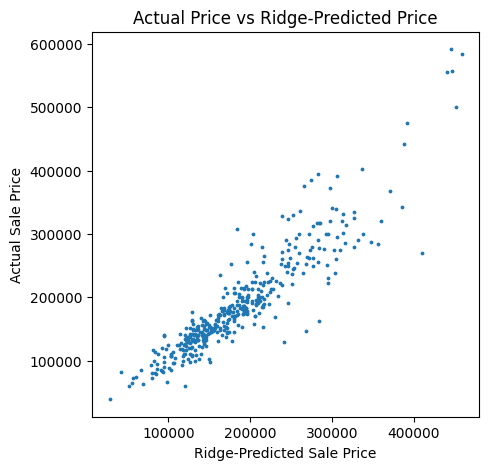

In [30]:
ridge_pred = ridge.predict(Xs_val)

ridge_resid = y_val - ridge_pred

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)

ax.scatter(ridge_pred, y_val, s=3)
ax.set_title('Actual Price vs Ridge-Predicted Price')
ax.set_xlabel('Ridge-Predicted Sale Price')
ax.set_ylabel('Actual Sale Price')
;

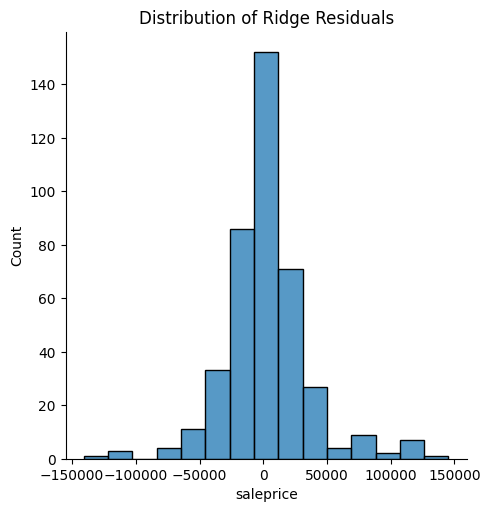

In [31]:
sns.displot(data=ridge_resid, bins=15).set(title='Distribution of Ridge Residuals');

### Lasso Model

In [32]:
lasso = LassoCV(alphas = np.arange(0.001, 10, 1))

In [33]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lasso.fit(Xs_train, y_train)

In [34]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print(model_outputs(lasso, Xs_train, Xs_val, y_train, y_val))

                                        score
Training score                       0.954956
Testing score                        0.787468
Training cross-validation score      0.731058
Testing cross-validation score      -0.026278
Training RMSE score              16677.753397
Testing RMSE score               37536.038756


The Lasso model of the third iteration is once more clearly overfit. The model performs very well on the training data, however there is high variance. Furthermore, the 5-fold cross-validation score of the testing data is miniscule and negative, proving that the Lasso model does not generalize well at all.

In [35]:
lasso.alpha_

7.0009999999999994

''

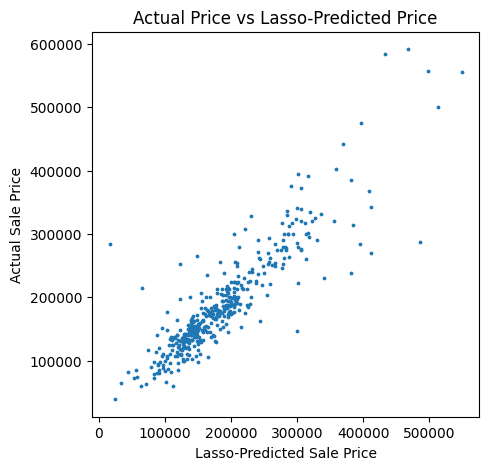

In [36]:
lasso_pred = lasso.predict(Xs_val)

lasso_resid = y_val - lasso_pred

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)

ax.scatter(lasso_pred, y_val, s=3)
ax.set_title('Actual Price vs Lasso-Predicted Price')
ax.set_xlabel('Lasso-Predicted Sale Price')
ax.set_ylabel('Actual Sale Price')
;

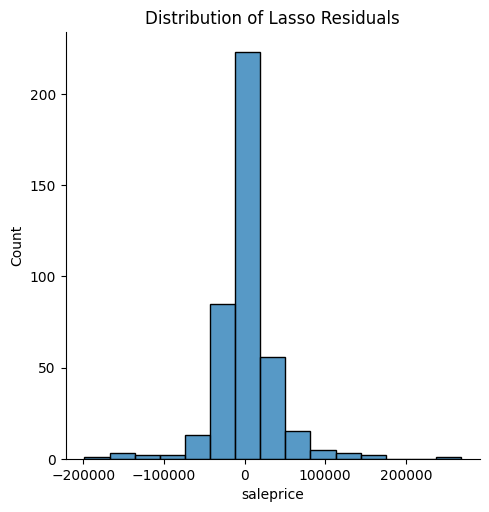

In [37]:
sns.displot(data=lasso_resid, bins=15).set(title='Distribution of Lasso Residuals');

### ElasticNet Model

In [38]:
enet = ElasticNetCV(
    l1_ratio=0.3, 
    alphas = np.arange(0.006, 0.01, 0.001))

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    enet.fit(Xs_train, y_train)

In [40]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print(model_outputs(enet, Xs_train, Xs_val, y_train, y_val))

                                        score
Training score                       0.952090
Testing score                        0.800054
Training cross-validation score      0.756036
Testing cross-validation score       0.523634
Training RMSE score              17200.063052
Testing RMSE score               36407.596957


Again, the ElasticNet model performs very well on the training data, but it is extremely high-variance and overfit. The model does not generalize well to new data.

In [41]:
enet.alpha_

0.007

''

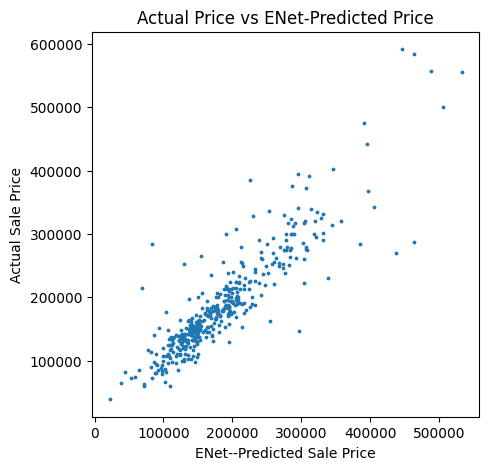

In [42]:
enet_pred = enet.predict(Xs_val)

enet_resid = y_val - enet_pred

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)

ax.scatter(enet_pred, y_val, s=3)
ax.set_title('Actual Price vs ENet-Predicted Price')
ax.set_xlabel('ENet--Predicted Sale Price')
ax.set_ylabel('Actual Sale Price')
;

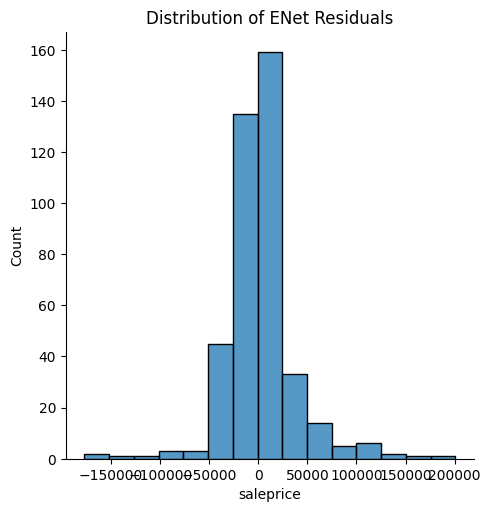

In [43]:
sns.displot(data=enet_resid, bins=15).set(title='Distribution of ENet Residuals');

### Predictions

In [44]:
df_test.head(1)

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,...,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type
0,2658,902301120,190,RM,9142,Pave,Reg,Lvl,AllPub,Inside,...,0,60,112,0,0,0,0,4,2006,WD


In [45]:
test_id = new_df_test['id']

In [46]:
new_df_test = poly.transform(new_df_test.drop(columns ='id'))

In [47]:
ridge_sub = Ridge(alpha = ridge.alpha_)

In [48]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    # preprocessed with standard scalar
    Xs_test = pd.DataFrame(
        ss.transform(new_df_test),
        columns = poly.get_feature_names_out()
    )

In [49]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    #fit
    ridge_sub.fit(Xs_train, y_train)

In [50]:
preds = ridge_sub.predict(Xs_test)

In [51]:
preds = pd.DataFrame({'Id': test_id, 'Saleprice': preds})

In [52]:
preds.head()

,Id,Saleprice
0,2658,122375.905423
1,2718,160698.854622
2,2414,187673.527535
3,1989,107642.094550
4,625,167479.951454


In [53]:
preds.to_csv('../prediction_results/ridge_3_medium.csv', index=False)